## FKA122: H2a | Jonatan Haraldsson & Oscar Stommendal - Group 19

### Import statements, constants and general functions

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as K
import pandas as pd

# Latex style
plt.style.use('default')
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('font', size=20)
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'
# Set ticks on both sides
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True

# Constants
k_B = K.Boltzmann
e = K.elementary_charge
k_B /= e
n_atoms = 2000

# Functions
def read_data(task, T, its_eq=0, its=0):
    if task == 2:
        if its_eq:
            eq_facts = np.genfromtxt(f'data/task_2/equilibrium_{its_eq}_{T}.csv', max_rows=1, delimiter=',', dtype=np.float64)
            eq_data = np.genfromtxt(f'data/task_2/equilibrium_{its_eq}_{T}.csv', delimiter=',', dtype=np.float64)[1:, :]
        else:
            eq_facts = None
            eq_data = None
        if its:
            atoms_data = np.genfromtxt(f'data/task_2/lattice/atoms_{its_eq}_{its}_{T}.csv')
            energy_facts = np.genfromtxt(f'data/task_2/energy_{its_eq}_{its}_{T}.csv', max_rows=2, delimiter=',', dtype=np.float64)[1]
            energy_data = np.genfromtxt(f'data/task_2/energy_{its_eq}_{its}_{T}.csv', delimiter=',', dtype=np.float64, skip_header=3)
        else:
            atoms_data = None
            energy_facts = None
            energy_data = None
    
    return eq_data, eq_facts, atoms_data, energy_data, energy_facts

def running_mean(x, N):
    M = len(x)
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    avg = (cumsum[N:] - cumsum[:-N]) / float(N)
    if len(avg) < M:
        avg = np.append(avg, avg[-1] * np.ones(M - len(avg)))
    return avg

def savitzky_golay(y, window_size, order, deriv=0, rate=1):
    '''Found here: https://scipy.github.io/old-wiki/pages/Cookbook/SavitzkyGolay'''
    from math import factorial 
    try:
        window_size = np.abs(int(window_size))
        order = np.abs(int(order))
    except ValueError:
        raise ValueError("window_size and order have to be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')

def plot_task_3(quantity,save):
    '''
    Plot data for task 3
    quantity: 'U', 'P'  or 'C'
    '''
    n_atoms = 2000
    if quantity != 'U' and quantity != 'P' and quantity != 'C' and quantity != 'r':
        raise ValueError('Invalid Quantity')
    
    if quantity == 'P':
        data = np.genfromtxt(f'data/task_3/P_r.csv', delimiter=',', dtype=np.float64)
        Y = data[1:, 1]
        N_Cu_A = data[1:, 1]
        Y = 2 * N_Cu_A / (n_atoms / 2) - 1
        T = data[1:, 0] 
        Y = np.abs(Y)

    elif quantity == 'r':
        data = np.genfromtxt(f'data/task_3/P_r.csv', delimiter=',', dtype=np.float64)
        Y = data[1:, 1]
        N_NN = data[1:, 2]
        Y = 0.25 *  (N_NN / n_atoms/2 - 4)
        T = data[1:, 0]
    else:
        data = np.genfromtxt(f'data/task_3/{quantity}.csv', delimiter=',', dtype=np.float64)
        Y = data[1:, 1]
        T = data[1:, 0]
    
    plt.figure()
    plt.plot(T, Y,color = 'tab:blue',alpha=1,linewidth = 1, label = f'Data Points, ${quantity}(T)$', marker='o')
    if quantity == 'U':
        plt.plot(T,savitzky_golay(Y, 5, 3), color = 'tab:red',linewidth = 2.7, label = 'Filtered',alpha=0.7, linestyle = '--')
    else:
        plt.plot(T,savitzky_golay(Y, 25, 9), color = 'tab:red',linewidth = 2.7, label = 'Filtered',alpha=0.7, linestyle = '--')
    plt.xlabel('$T$ [K]')
    plt.ylabel(f'${quantity}(T)$')
    plt.legend(fontsize = 17)
    if save:
        plt.savefig(f'figs/task_3/{quantity}_T_metro.pdf', bbox_inches='tight')
        plt.tight_layout()
    plt.show()


### Task 1 - Temperature dependence of $P$, $U$ and $C_V$ using Mean Field Theory

T_c = 226.28810337022614


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


94.711788
148.32254
157.244897
162.981204
167.311891
170.832795
173.821388
176.430877
178.755349
180.856988
182.779166
184.553413
186.203411
187.74743
189.199878
190.57233
191.874234
193.113411
194.29641
195.428773
196.515238
197.559884
198.566255
199.537447
200.476183
201.38487
202.26565
203.120436
203.950942
204.758714
205.54515
206.311517
207.058969
207.788561
208.501257
209.197944
209.879436
210.546488
211.199794
211.840001
212.467706
213.083467
213.687804
214.281202
214.864114
215.436966
216.000155
216.554057
217.099024
217.635387
218.16346
218.683538
219.195901
219.700813
220.198525
220.689273
221.173285
221.650774
222.121944
222.586989
223.046095
223.499437
223.947183
224.389496
224.826527
225.258425
225.68533
226.107376
226.524692
226.937403
227.345628
227.749479
228.149068
228.544499
228.935873
229.323289
229.70684
230.086617
230.462706
230.835192
231.204156
231.569677
231.931829
232.290687
232.64632
232.998796
233.348183
233.694543
234.037939
234.37843
234.716074
235.050928
2

KeyboardInterrupt: 

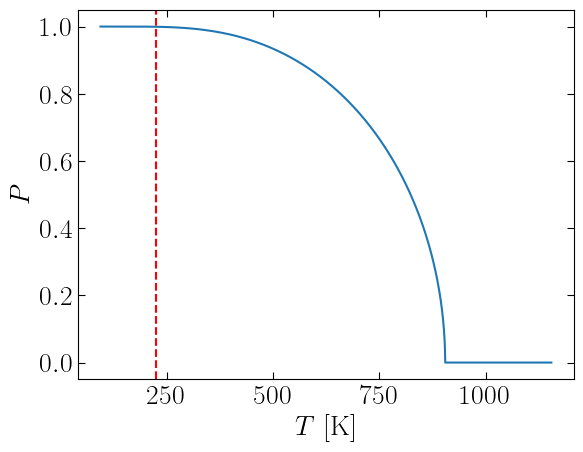

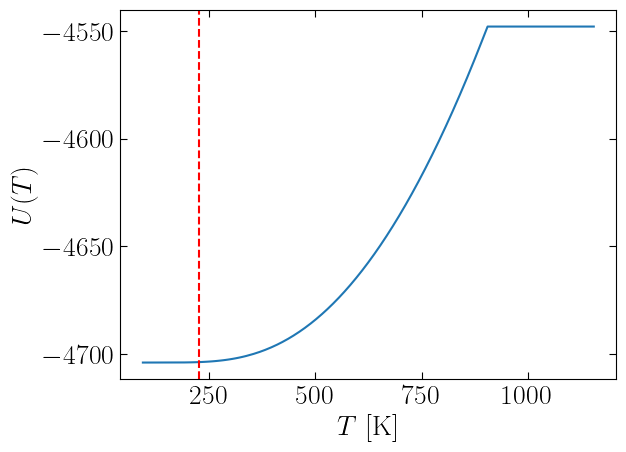

In [315]:

path = 'data/task_1/P_T.csv'
data = np.loadtxt(path, delimiter=',')

T = data[:, 1]
P = data[:, 0]

T = T[:np.argmin(abs(P))]
P = P[:np.argmin(abs(P))]


E_cucu = -0.436
E_znzn = -0.113
E_cuzn = -0.294
delta_E = E_cucu + E_znzn - 2*E_cuzn
T_c = 0.5*delta_E/k_B
print(f'T_c = {T_c}')
T_over_Tc = np.linspace(np.max(data[:, 1]), np.max(data[:, 1]) + 250, 1000)


T = np.append(T, T_over_Tc)
P = np.append(P, np.zeros(len(T_over_Tc)))

plt.figure()
plt.plot(T[:-1],abs(P[:-1]))
#plt.plot(T_over_Tc, np.zeros(len(T_over_Tc)), 'tab:blue')
plt.axvline(x=T_c, color='r', linestyle='--')
plt.xlabel('$T$ [K]')
plt.ylabel('$P$')
plt.savefig('figs/task_1/P_T.pdf', bbox_inches='tight')


u_T = 2*n_atoms*(E_cucu + E_znzn + 2*E_cuzn)*np.ones(len(T)) - 2*P**2*delta_E * n_atoms
plt.figure()
plt.plot(T,u_T)
#plt.plot(T_over_Tc, np.ones(len(T_over_Tc))*2*n_atoms*(E_cucu + E_znzn + 2*E_cuzn), 'tab:blue')
plt.axvline(x=T_c, color='r', linestyle='--')
plt.xlabel('$T$ [K]')
plt.ylabel('$U(T)$')
plt.savefig('figs/task_1/U_T.pdf', bbox_inches='tight')


j = 0
T_i = []
c_V = []
for i in range(0,int(len(T))-1):
    
    if abs(P[i]) >0.90 and i % 1000 == 0:
        T_i.append(T[i])
        c_V.append(np.var(u_T[:i]) / (k_B * T[i]**2))
        #c_V.append(abs(u_T[i] - u_T[i+1] / (T[i] - T[i+1])))
        print(T[i])
    elif abs(P[i]) < 0.90:
        T_i.append(T[i])
        #c_V.append(abs(u_T[i] - u_T[i+1] / (T[i] - T[i+1])))
        c_V.append(np.var(u_T[-i:]) / (k_B * T[-i]**2))

    #if i % int(len(data[:,1])/50) == 0:
        #print(f'{i}/{len(data[:,1])}')

plt.figure()
plt.plot(T_i,c_V)
plt.axvline(x=T_c, color='r', linestyle='--')
plt.xlabel('$T$ [K]')
plt.ylabel('$C_V$')
plt.savefig('figs/task_1/C_T.pdf', bbox_inches='tight')
plt.tight_layout()

plt.show()

### Task 2 - Calculating $U$ using the Metropolis Algorithm 

In [ ]:

its_eq_400 = 200000
its_eq = 100000
its = 1000000

# data_eq_400, eq_facts_400 , _, _, _ = read_data(2, 400, its_eq=its_eq_400)
# data_eq_600, eq_facts_600 , _, _, _ = read_data(2, 600, its_eq=its_eq)
# data_eq_1000, eq_facts_1000 , _, _, _ = read_data(2, 1000, its_eq=its_eq)

# fig, axs = plt.subplots(2, 1, sharex=True)
# axs[0].plot(data_eq_400[:, 0])
# axs[1].plot(data_eq_400[:, 1])
# axs[0].set_ylabel('Accepted steps')
# axs[1].set_ylabel('Potential energy')
# axs[1].set_xlabel('MC steps')

# fig, axs = plt.subplots(2, 1, sharex=True)
# axs[0].plot(energy_data[:, 0])
# axs[1].plot(energy_data[:, 1])
# axs[0].set_ylabel('Accepted steps')
# axs[1].set_ylabel('Potential energy')
# axs[1].set_xlabel('MC steps')

# plt.tight_layout()
# plt.show()

_, _, atoms_data_400, energy_data_400, energy_facts_400 = read_data(2, 400, its_eq=its_eq_400, its=its)
_, _, atoms_data_600, energy_data_600, energy_facts_600 = read_data(2, 600, its_eq=its_eq, its=its)
_, _, atoms_data_1000, energy_data_1000, energy_facts_1000 = read_data(2, 1000, its_eq=its_eq, its=its)

accept_400_eq = energy_facts_400[1]
accept_600_eq = energy_facts_600[1]
accept_1000_eq = energy_facts_1000[1]
Epot_400 = np.mean(energy_data_400[:, 1])
Epot_600 = np.mean(energy_data_600[:, 1])
Epot_1000 = np.mean(energy_data_1000[:, 1])

df = pd.DataFrame({'T': [400, 600, 1000], 'Epot': [Epot_400, Epot_600, Epot_1000], 
                   'N_eq': [its_eq_400, its_eq, its_eq], 'Acceptance_eq': [accept_400_eq, accept_600_eq, accept_1000_eq]})
display(df)


,T,Epot,N_eq,Acceptance_eq
0,400,-583.909018,200000,0.018165
1,600,-563.172920,100000,0.101110
2,1000,-520.629598,100000,0.592380


### Task 3

#### a) Temperature dependence of $U$, $C_V$, $P$ and $r$ using MFT

In [ ]:
""" 
data_U = np.genfromtxt('data/task_3/U.csv', delimiter=',', dtype=np.float64)
T = data_U[1:, 0]
E = data_U[1:, 1]



plt.figure()
#plt.plot(T, running_mean(E, 3), color = 'black',linewidth = 2, label = 'Running mean')
plt.plot(T, E,color = 'tab:blue',alpha=1,linewidth = 1, label = 'Data Points, $E(T)$', marker='o')
plt.plot(T,savitzky_golay(E, 5, 3), color = 'tab:red',linewidth = 2.7, label = 'Filtered',alpha=0.7)
#plt.plot(smooth(T,E,4)[0],smooth(T,E,4)[1],color = 'tab:green',alpha=0.85,linewidth = 1, label = 'Data Points')
plt.xlabel('$T$ [K]')
plt.ylabel('$E$')
plt.legend(fontsize = 17)
plt.savefig('figs/task_3/E_T_metro.pdf', bbox_inches='tight')
plt.tight_layout()
plt.show()

data_P = np.genfromtxt('data/task_3/P_r.csv', delimiter=',', dtype=np.float64)
T = data_P[1:, 0]
N_Cu_A = data_P[1:, 1]
P = 2 * N_Cu_A / (n_atoms / 2) - 1

plt.figure()
plt.plot(T, P,color = 'tab:blue',alpha=1,linewidth = 1, label = 'Data Points, $P(T)$', marker='o')
#plt.plot(T, running_mean(abs(P), 2), color = 'black',linewidth = 2, label = 'Running mean')
plt.plot(T,savitzky_golay(abs(P), 25, 9), color = 'tab:red',linewidth = 2.7, label = 'Filtered',alpha=0.7)
#plt.plot(smooth(T,abs(P),20)[0],smooth(T,abs(P),20)[1],color = 'tab:green',alpha=1,linewidth = 2, label = 'Data Points')
plt.xlabel('$T$ [K]')
plt.ylabel('$P$')
plt.legend(fontsize = 17)
plt.savefig('figs/task_3/P_T_metro.pdf', bbox_inches='tight')
plt.tight_layout()
plt.show()

E_diff = np.diff(E)
T_diff = np.diff(T)
C_V = E_diff / T_diff

plt.figure()
#plt.plot(T[1:], C_V, 'ko')
#plt.plot(T[1:], running_mean(C_V, 2), color = 'black',linewidth = 2, label = 'Running mean')
plt.plot(T[1:], C_V,color = 'tab:blue',alpha=1,linewidth = 1, label = 'Data Points $C(T)$', marker='o')
plt.plot(T[1:],savitzky_golay(C_V, 25,9), color = 'tab:red',linewidth = 2.7, label = 'Filtered',alpha=0.7)
#plt.plot(smooth(T[1:],C_V,10)[0],smooth(T[1:],C_V,10)[1],color = 'tab:green',alpha=0.85,linewidth = 1, label = 'Data Points')
plt.legend(fontsize = 17)

plt.xlabel('$T$ [K]')
plt.ylabel('$C_V$')
plt.savefig('figs/task_3/C_T_metro.pdf', bbox_inches='tight')
plt.tight_layout()
plt.show()
"""

" \ndata_U = np.genfromtxt('data/task_3/U.csv', delimiter=',', dtype=np.float64)\nT = data_U[1:, 0]\nE = data_U[1:, 1]\n\n\n\nplt.figure()\n#plt.plot(T, running_mean(E, 3), color = 'black',linewidth = 2, label = 'Running mean')\nplt.plot(T, E,color = 'tab:blue',alpha=1,linewidth = 1, label = 'Data Points, $E(T)$', marker='o')\nplt.plot(T,savitzky_golay(E, 5, 3), color = 'tab:red',linewidth = 2.7, label = 'Filtered',alpha=0.7)\n#plt.plot(smooth(T,E,4)[0],smooth(T,E,4)[1],color = 'tab:green',alpha=0.85,linewidth = 1, label = 'Data Points')\nplt.xlabel('$T$ [K]')\nplt.ylabel('$E$')\nplt.legend(fontsize = 17)\nplt.savefig('figs/task_3/E_T_metro.pdf', bbox_inches='tight')\nplt.tight_layout()\nplt.show()\n\ndata_P = np.genfromtxt('data/task_3/P_r.csv', delimiter=',', dtype=np.float64)\nT = data_P[1:, 0]\nN_Cu_A = data_P[1:, 1]\nP = 2 * N_Cu_A / (n_atoms / 2) - 1\n\nplt.figure()\nplt.plot(T, P,color = 'tab:blue',alpha=1,linewidth = 1, label = 'Data Points, $P(T)$', marker='o')\n#plt.plot(T, r

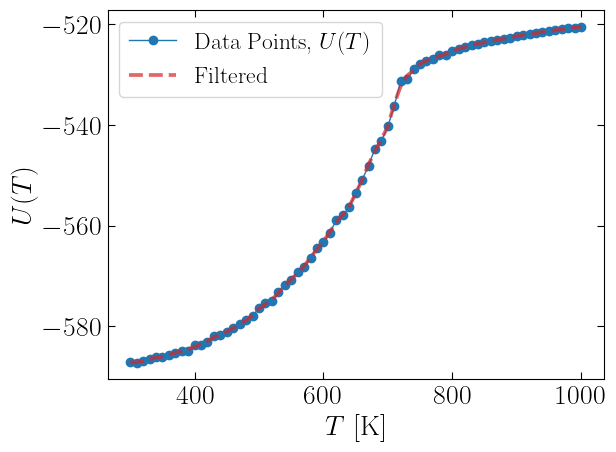

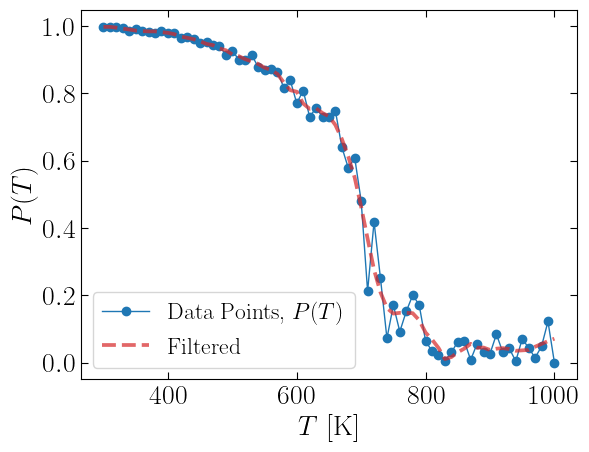

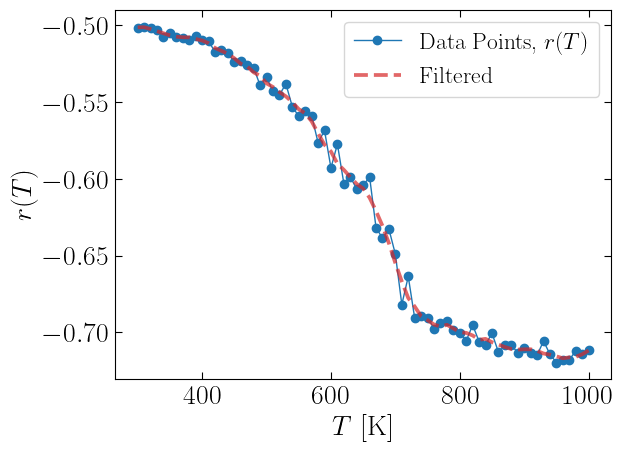

In [ ]:
plot_task_3('U', False)
plot_task_3('P', False)
plot_task_3('r', False)

#### b) Error estimation using block average and autocorrelation